In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('eth.csv')
print(df)

      Unnamed: 0 formatted_date         high          low         open  \
0              0     2019-01-01   141.397507   132.650711   141.519516   
1              1     2019-01-02   156.929138   140.650955   155.196045   
2              2     2019-01-03   155.863052   147.198364   148.912888   
3              3     2019-01-04   156.878983   147.907104   154.337418   
4              4     2019-01-05   160.824890   154.337418   155.804230   
...          ...            ...          ...          ...          ...   
1515        1515     2023-02-24  1661.091309  1583.147827  1608.658325   
1516        1516     2023-02-25  1608.865112  1567.631714  1594.761108   
1517        1517     2023-02-26  1645.273438  1590.393066  1640.763672   
1518        1518     2023-02-27  1662.575684  1615.387939  1634.502441   
1519        1519     2023-02-28  1644.435791  1602.428101  1606.040405   

            close      volume     adjclose  
0      140.819412  2258709868   140.819412  
1      155.047684  33

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['close'].rolling(window=ma_3).std()
df.dropna(inplace=True)
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,119.715439,116.157440,117.110756,117.157852,2421720343,117.157852,3.557999,121.640524,127.196642,135.496240,2.635404,15.088666
21,21,2019-01-22,119.664345,114.676682,118.713814,118.747551,2552507405,118.747551,4.987663,121.171215,124.938636,134.445199,2.838598,15.463410
22,22,2019-01-23,119.422798,116.376648,117.462784,117.452606,2556952198,117.452606,3.046150,120.300577,122.556456,132.654957,2.921848,15.131627
23,23,2019-01-24,118.032104,116.006798,117.594955,117.362885,2520843420,117.362885,2.025307,119.389287,121.752007,131.141999,2.651955,14.989176
24,24,2019-01-25,117.802994,115.830154,116.373528,116.378342,2606881898,116.378342,1.972839,118.727584,120.954151,129.322780,2.755917,14.304793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,1661.091309,1583.147827,1608.658325,1608.373169,8909129423,1608.373169,77.943481,1662.377982,1626.017447,1622.058291,32.361529,64.912140
1516,1516,2023-02-25,1608.865112,1567.631714,1594.761108,1594.914917,5657686235,1594.914917,41.233398,1648.534476,1629.945173,1618.622849,37.917844,64.317786
1517,1517,2023-02-26,1645.273438,1590.393066,1640.763672,1640.817139,5727967432,1640.817139,54.880371,1642.731759,1638.929705,1619.059576,35.042625,64.441653
1518,1518,2023-02-27,1662.575684,1615.387939,1634.502441,1634.326416,7239824677,1634.326416,47.187744,1632.967651,1648.012599,1619.920497,23.014437,64.522916


In [4]:
pre_day = 7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.1)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

150
(1343, 7, 9) (1343, 1) (150, 7, 9) (150, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_close.h5")

Epoch 1/120
40/40 [==============================] - 31s 18ms/step - loss: 0.0144
Epoch 2/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0048
Epoch 3/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0040
Epoch 4/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0039
Epoch 5/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0041
Epoch 6/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0032
Epoch 7/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0034
Epoch 8/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0030
Epoch 9/120
40/40 [==============================] - 1s 15ms/step - loss: 0.0035
Epoch 10/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0031
Epoch 11/120
40/40 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 12/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0034
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

42/42 [==============================] - 2s 4ms/step
      predict_price  y_train_price  error_price
0        163.538177     106.589973    56.948204
1        157.412506     105.598213    51.814293
2        153.144058     108.907539    44.236519
3        154.070023     107.061012    47.009010
4        155.599869     107.609787    47.990082
...             ...            ...          ...
1338    1350.924194    1330.127686    20.796509
1339    1373.177124    1337.410889    35.766235
1340    1356.903320    1335.652344    21.250977
1341    1355.973511    1327.978638    27.994873
1342    1360.566040    1311.644409    48.921631

[1343 rows x 3 columns]


In [7]:

from sklearn.linear_model import ElasticNet
import pickle
elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_close.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

5/5 [==============================] - 0s 6ms/step
[[0.26177043]
 [0.2543486 ]
 [0.25755697]
 [0.2651564 ]
 [0.26309627]
 [0.26493767]
 [0.2604186 ]
 [0.25564063]
 [0.25617576]
 [0.25224087]
 [0.24759574]
 [0.24892616]
 [0.24688724]
 [0.25380623]
 [0.24927083]
 [0.2527826 ]
 [0.25744224]
 [0.2568216 ]
 [0.2524041 ]
 [0.25026077]
 [0.25080252]
 [0.2547602 ]
 [0.26225337]
 [0.26311204]
 [0.2816193 ]
 [0.3044876 ]
 [0.3051852 ]
 [0.30886385]
 [0.3240779 ]
 [0.32357004]
 [0.32174763]
 [0.31930107]
 [0.30926517]
 [0.3061433 ]
 [0.32331422]
 [0.32848033]
 [0.31947222]
 [0.31534246]
 [0.2754815 ]
 [0.22470842]
 [0.24101546]
 [0.25216395]
 [0.2544444 ]
 [0.250071  ]
 [0.2523795 ]
 [0.24943453]
 [0.24241772]
 [0.23585823]
 [0.23824173]
 [0.24075717]
 [0.23132716]
 [0.21941547]
 [0.22151372]
 [0.23135373]
 [0.2375928 ]
 [0.23558168]
 [0.2366205 ]
 [0.2328913 ]
 [0.22608328]
 [0.2318395 ]
 [0.24484742]
 [0.24738392]
 [0.24926262]
 [0.245142  ]
 [0.2468749 ]
 [0.24786684]
 [0.24642988]
 [0.2408507

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[1363.2927]
 [1328.3541]
 [1343.4578]
 [1379.2324]
 [1369.5343]
 [1378.2029]
 [1356.929 ]
 [1334.4364]
 [1336.9556]
 [1318.4318]
 [1296.5647]
 [1302.8276]
 [1293.2292]
 [1325.8008]
 [1304.4501]
 [1320.982 ]
 [1342.9176]
 [1339.9958]
 [1319.2002]
 [1309.1104]
 [1311.6606]
 [1330.2917]
 [1365.5663]
 [1369.6086]
 [1456.7328]
 [1564.3866]
 [1567.6707]
 [1584.9883]
 [1656.6093]
 [1654.2185]
 [1645.6394]
 [1634.1221]
 [1586.8774]
 [1572.181 ]
 [1653.0143]
 [1677.3341]
 [1634.9279]
 [1615.4866]
 [1427.8385]
 [1188.821 ]
 [1265.5874]
 [1318.0696]
 [1328.805 ]
 [1308.2169]
 [1319.0844]
 [1305.2207]
 [1272.1886]
 [1241.3093]
 [1252.5299]
 [1264.3715]
 [1219.9792]
 [1163.9042]
 [1173.7817]
 [1220.1042]
 [1249.4751]
 [1240.0076]
 [1244.898 ]
 [1227.3425]
 [1195.2932]
 [1222.391 ]
 [1283.6266]
 [1295.5674]
 [1304.4115]
 [1285.0134]
 [1293.1711]
 [1297.8408]
 [1291.0763]
 [1264.8119]
 [1288.2108]
 [1297.449 ]
 [1295.2493]
 [1294.0251]
 [1288.7859]
 [1326.9276]
 [1341.0043]
 [1303.2085]
 [1223.1539]

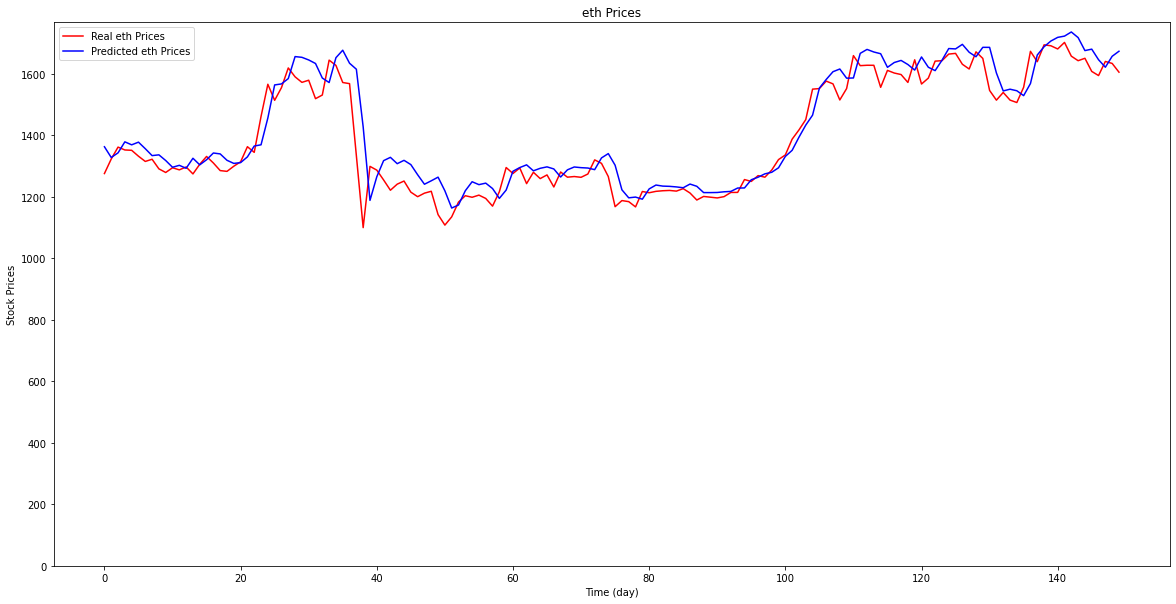

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real eth Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted eth Prices")
plt.title(f"eth Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 43.72
MAPE: 3.18%
MSE: 3848.66
RMSE: 62.04
R2: 0.88


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))